In [1]:
import sys
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
import time
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution, greedy_2_regret_weighted, score, get_random_solution
from typing import Callable, Tuple
from abc import ABC, abstractmethod
from sortedcontainers import SortedList
import random
import numba

In [2]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [3]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass


In [4]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))
        self.indexes=np.array(self.indexes)
        self.size=len(self.indexes)
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        n = 100
        if indexes is None:
            indexes = np.arange(len(self.indexes))
        selected_indexes = self.indexes[indexes]
        i_vals, j_vals = selected_indexes[:, 0], selected_indexes[:, 1]
        s=np.array(solution)
        i1 = s[(i_vals - 1) % n]
        i2 = s[i_vals]
        j1 = s[j_vals]
        j2 = s[(j_vals + 1) % n]
        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    def get_difference(self, ind, solution: List[int], unselected: SortedList):
        n = 100
        i, j = self.indexes[ind]

        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        start = i - 1
        end = j + 2
        reversed_segment = set(range(start, end)) 
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in reversed_segment or y in reversed_segment:
                affected.add(k)

        return list(affected)

    
class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))
        self.indexes=np.array(self.indexes)

        self.size=len(self.indexes)
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected_list: List[int], indexes=None):
        if indexes is None:
            indexes = np.arange(len(self.indexes)) 
        n = 100
        selected_indexes = self.indexes[indexes]
        indices_i, indices_j = selected_indexes[:, 0], selected_indexes[:, 1]
        i_prev = (indices_i - 1) % n
        i_next = (indices_i + 1) % n
        s=np.array(solution)
        u=np.array(unselected_list)
        node_prev = s[i_prev]
        node_current =s[indices_i]  
        node_next = s[i_next]
        node_unselected = u[indices_j]
        differences = (
            -self.dist_mat[node_prev, node_current]
            - self.dist_mat[node_current, node_next]
            + self.dist_mat[node_prev, node_unselected]
            + self.dist_mat[node_unselected, node_next]
        )
        return differences
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        n = len(solution)
        adjacent_indices = { (i - 1) % n, (i + 1) % n, i }
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in adjacent_indices or y in adjacent_indices:
                affected.add(k)
            if y == j:
                affected.add(k)
        
        return list(affected)

class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
     
        self.offsets = np.cumsum([0] + [n.neighborhood_size() for n in neighborhoods])
        self.size = self.offsets[-1]
        self.indexes = np.concatenate(
            [n.indexes for  n in neighborhoods]
        )
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        if indexes is None:
            differences = []
            for neighborhood in self.neighborhoods:
                differences.append(neighborhood.batch_get_differences(solution, unselected))
            return np.concatenate(differences)
        else:
            differences = []
            idx=0
            
            id1=0
            for neighborhood in self.neighborhoods:
                idx+=neighborhood.size
                idxs=np.array(indexes)
                idxs=idxs[idxs>id1]
                idxs=idxs[idxs<idx] 
                idxs=idxs-id1
                differences.append(neighborhood.batch_get_differences(solution, unselected, idxs))
                id1+=idx
            return np.concatenate(differences)
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
            size=self.neighborhoods[0].neighborhood_size()
            if ind < size:
                return self.neighborhoods[0].get_affected_indexes(ind, solution)
            else:
                ind-=size
                return [x+size for x in self.neighborhoods[1].get_affected_indexes(ind, solution)]
            

In [5]:
def steepest(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)

    solution = starting_solution.copy()

    while True:
        objective_changes = neighborhood.batch_get_differences(solution, unselected)
        best_index = np.argmin(objective_changes)
    
        if objective_changes[best_index] >= 0:
            return solution
    
        solution = neighborhood.modify_solution(best_index, solution, unselected)


In [6]:
def msls( distance_matrix, costs, neighborhood,number_of_iterations=200):
    solutions=[get_random_solution(200) for x in range(number_of_iterations)]
    best_fit=999999999
    best_sol=None
    for sol in solutions:
        s=steepest(sol, dist, costs, neighborhood)
        if score(s, distance_matrix, costs) < best_fit:
            best_fit=score(s, distance_matrix, costs)
            best_sol=s
    return best_sol

In [7]:
def ils(pert_f, distance_matrix, costs, neighborhood):
    x=get_random_solution(200)
    best_fit=999999999
    best_sol=None
    start_time=time.time()
    i=0
    previous_score=score(x, distance_matrix, costs)
    while time.time()-start_time<25:
        y=x.copy()
        for function in pert_f:
            y=function(y)
        
        y=steepest(y, dist, costs, neighborhood)
      
        scor=score(y, distance_matrix, costs)
        if scor<previous_score:
            x=y
        i+=1
        if  scor< best_fit:
            best_fit=scor
            best_sol=y
    return best_sol, i

In [8]:
n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])


In [9]:
def per(sol):
    un=[x for x in range(200) if x not in sol]
    np.random.shuffle(un)
    sol=sol[:97]+un[:3]
    return sol

In [10]:
def rswap(sol):
    i=np.random.randint(0,90)
    j=i+10
    tmp=sol[i]
    sol[i]=sol[j]
    sol[j]=tmp
    return sol

In [11]:
def shuff(sol):
    i=np.random.randint(0,90)
    j=i+10
    s=sol[i:j]
    np.random.shuffle(s)
    sol[i:j]=s
    return sol

In [12]:
def invert(sol):
    i=np.random.randint(0,100)
    j=np.random.randint(0,100)
    sol[i:j]=sol[i:j][::-1]
    return sol

In [13]:
def test_method(Neighborhood: CombinedNeighborhood, dist, costs, coordinates, pert_f,name='',):
    scores_2=[]
    sols_2=[]
    times = list()
    i1=[]
    for x in range(20):
        begin_time = time.time()
        if len(pert_f)==0:
            solution_2=msls( dist, costs, Neighborhood)
        else:
            solution_2, i=ils(pert_f, dist, costs, Neighborhood)
            i1.append(i)
        times.append(time.time() - begin_time)

        solution_2 = [int(e) for e in solution_2]
        sols_2.append(solution_2)
        scores_2.append(score(solution_2, dist, costs))   
    print('scores: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
    print(sols_2[scores_2.index(min(scores_2))])
    print(f'execution time: {min(times)} {sum(times)/len(times)} {max(times)}')
    if len(i1)>0:
        print(f'ils iterations: ', min(i1), sum(i1)/len(i1), max(i1))
    plot_solution(sols_2[scores_2.index(min(scores_2))], coordinates, costs, f'best solution for {name}')

In [14]:
n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])

In [15]:
from itertools import combinations
p=[per, invert, shuff, rswap]
all_combinations = []
for r in range(len(p) + 1): 
    all_combinations.extend(combinations(p, r))
all_combinations = [list(combo) for combo in all_combinations]



scores:  69388 69706.3 69952
[16, 171, 175, 113, 56, 31, 78, 145, 196, 81, 90, 165, 119, 40, 185, 179, 92, 129, 57, 55, 52, 106, 178, 49, 14, 144, 102, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18, 22, 146, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 131, 149, 65, 116, 43, 42, 159, 193, 41, 139, 68, 46, 115, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25]
execution time: 25.00174045562744 25.003524351119996 25.008796215057373
ils iterations:  2883 3299.6 3365


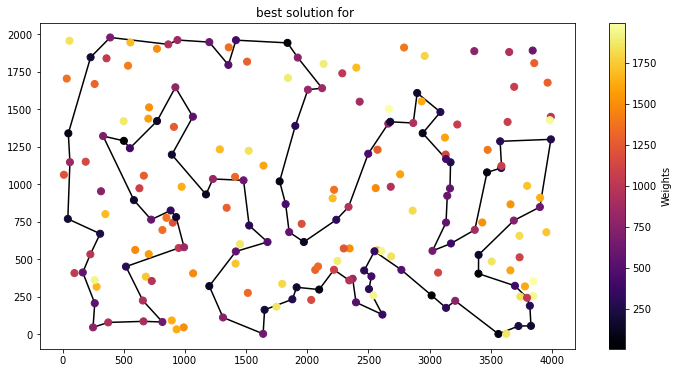

In [16]:
test_method(neighborhood, dist, costs, coordinates, pert_f=[shuff], name='')

scores:  70655 71402.75 71937
[129, 92, 57, 179, 145, 78, 16, 171, 175, 113, 56, 31, 157, 196, 81, 90, 27, 165, 119, 40, 185, 55, 52, 106, 178, 3, 138, 14, 49, 102, 144, 62, 9, 148, 167, 124, 94, 63, 79, 80, 176, 137, 23, 89, 183, 143, 0, 117, 93, 108, 69, 18, 22, 159, 193, 41, 139, 46, 115, 5, 42, 43, 184, 48, 160, 34, 30, 54, 177, 4, 112, 131, 149, 65, 116, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25]
execution time: 24.133565187454224 24.4541415810585 25.314690828323364


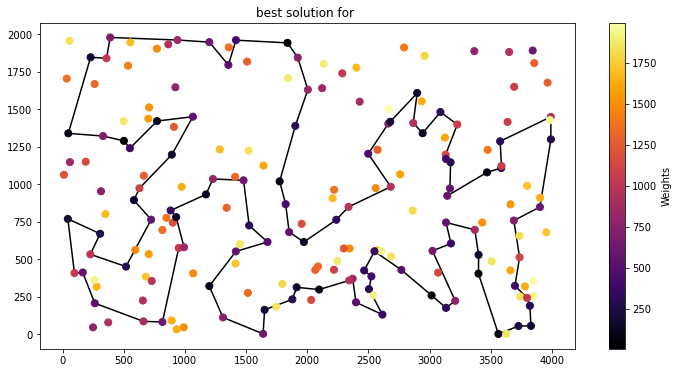

scores:  70689 72297.05 74416
[144, 14, 49, 178, 106, 52, 55, 57, 129, 92, 78, 145, 185, 40, 119, 165, 39, 164, 27, 90, 81, 196, 157, 31, 56, 113, 175, 171, 16, 25, 44, 120, 75, 101, 1, 2, 152, 97, 26, 100, 86, 53, 180, 154, 70, 135, 133, 151, 51, 118, 59, 162, 123, 127, 112, 4, 84, 184, 190, 10, 177, 54, 48, 160, 34, 181, 42, 43, 65, 116, 115, 41, 193, 159, 146, 22, 18, 108, 69, 139, 46, 68, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 148, 9, 62]
execution time: 25.000001668930054 25.002879798412323 25.004982948303223
ils iterations:  3983 4632.8 5111


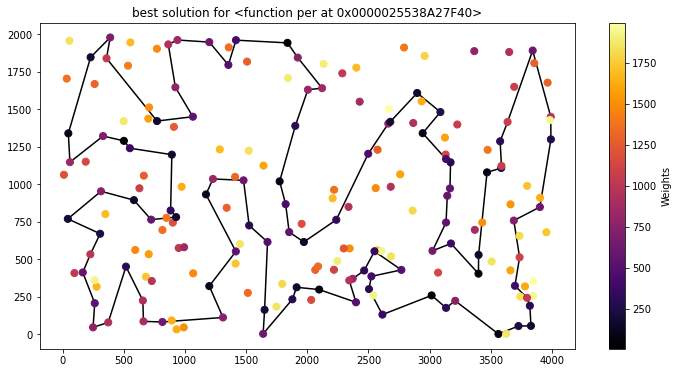

scores:  70230 72385.65 76312
[62, 9, 148, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18, 22, 146, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 43, 42, 181, 159, 193, 41, 139, 46, 115, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 82, 129, 92, 57, 179, 145, 78, 16, 171, 175, 113, 56, 31, 38, 157, 196, 81, 90, 165, 40, 185, 55, 52, 106, 178, 3, 49, 14, 144, 102]
execution time: 25.000001192092896 25.000866520404816 25.002995252609253
ils iterations:  13560 13646.4 13729


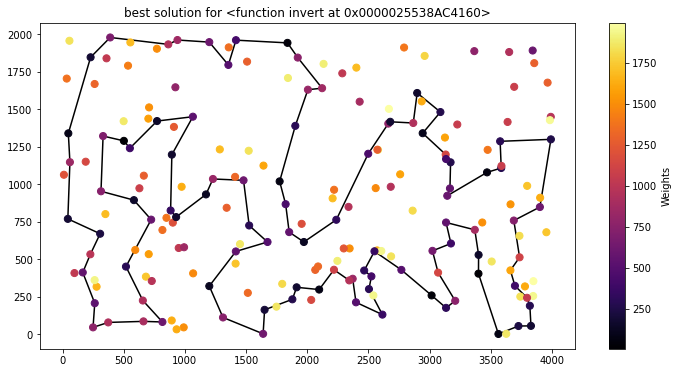

scores:  69731 70106.95 70422
[154, 135, 70, 127, 123, 162, 133, 151, 51, 59, 65, 116, 115, 46, 68, 139, 41, 193, 159, 181, 42, 43, 149, 131, 184, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 146, 22, 18, 69, 108, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 148, 9, 62, 102, 144, 14, 49, 3, 178, 106, 52, 55, 185, 40, 119, 165, 90, 81, 196, 179, 57, 129, 92, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100, 53, 180]
execution time: 25.000993490219116 25.01474586725235 25.05400252342224
ils iterations:  1450 1588.45 1726


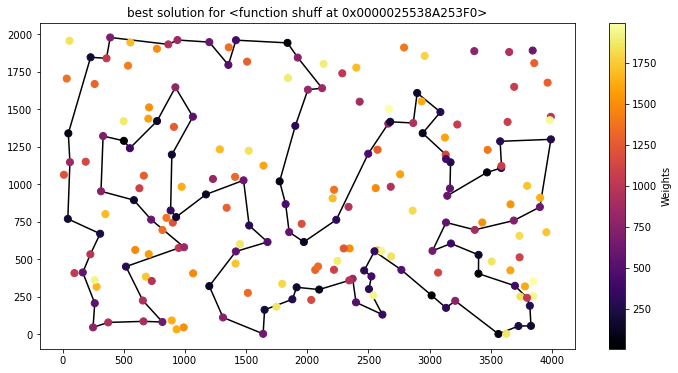

scores:  69827 70519.45 72708
[146, 181, 34, 160, 48, 54, 30, 177, 10, 190, 184, 35, 84, 4, 112, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 179, 92, 129, 57, 55, 52, 178, 106, 185, 40, 119, 165, 90, 164, 7, 21, 144, 14, 49, 102, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 68, 46, 139, 115, 59, 118, 51, 151, 133, 162, 149, 131, 65, 116, 43, 42, 41, 193, 159, 108, 18, 22]
execution time: 25.000001907348633 25.001403415203093 25.003002643585205
ils iterations:  7738 7778.9 7811


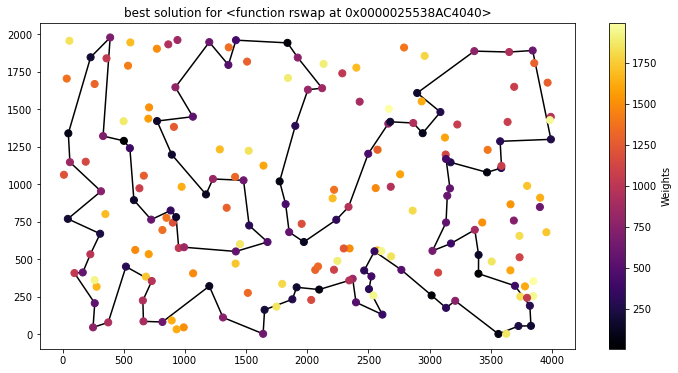

scores:  70044 70739.05 71343
[115, 46, 139, 41, 193, 159, 181, 160, 184, 84, 112, 4, 190, 10, 177, 54, 34, 146, 22, 18, 69, 108, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 51, 118, 59, 162, 151, 133, 79, 63, 94, 124, 148, 9, 62, 102, 49, 178, 106, 14, 144, 21, 7, 164, 27, 90, 165, 40, 185, 52, 55, 57, 92, 179, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 82, 129, 2, 75, 86, 101, 1, 152, 97, 26, 100, 53, 180, 154, 135, 70, 127, 123, 149, 65, 116, 43, 42]
execution time: 25.00002098083496 25.00355248451233 25.00800323486328
ils iterations:  4043 4104.8 4199


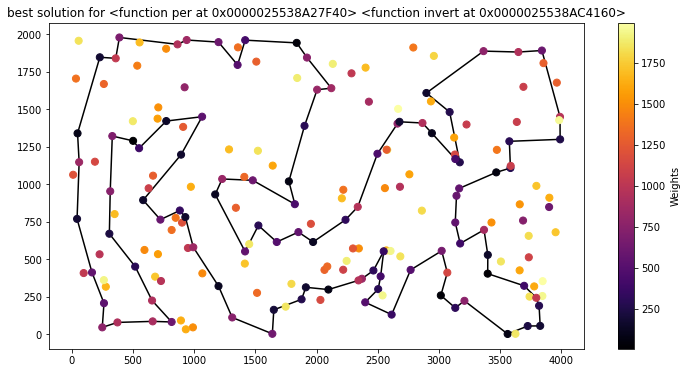

scores:  69786 70581.45 70944
[80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 108, 69, 18, 22, 146, 34, 160, 48, 54, 177, 10, 184, 84, 4, 112, 123, 149, 131, 65, 116, 43, 42, 181, 159, 193, 41, 139, 68, 46, 115, 59, 118, 51, 151, 133, 162, 127, 70, 135, 154, 180, 53, 100, 26, 97, 152, 1, 101, 86, 75, 2, 129, 92, 57, 179, 145, 78, 120, 44, 25, 16, 171, 175, 113, 56, 31, 157, 196, 81, 90, 165, 119, 40, 185, 55, 52, 106, 178, 49, 14, 144, 102, 62, 9, 148, 124, 94, 63, 79]
execution time: 25.000991106033325 25.02185837030411 25.071003198623657
ils iterations:  1123 1207.5 1283


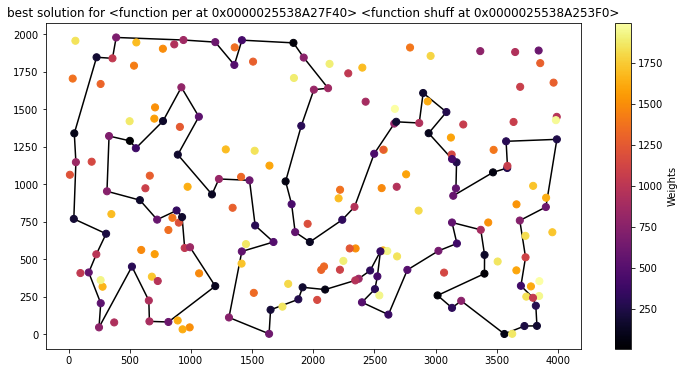

scores:  69833 70630.8 71154
[165, 40, 185, 179, 145, 78, 92, 129, 57, 55, 52, 106, 178, 14, 144, 49, 102, 62, 9, 148, 124, 94, 63, 122, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46, 115, 139, 41, 193, 159, 69, 108, 18, 22, 146, 34, 181, 42, 160, 48, 54, 30, 177, 10, 190, 4, 112, 84, 184, 43, 116, 65, 59, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 196, 81, 90]
execution time: 25.001002550125122 25.004417538642883 25.011000633239746
ils iterations:  3217 3261.6 3321


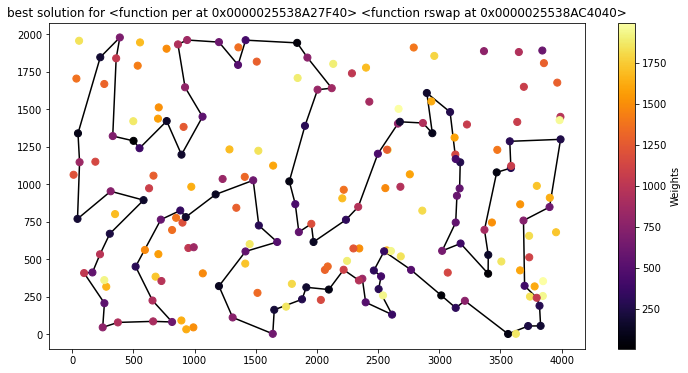

scores:  69728 70139.95 70328
[62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18, 69, 139, 68, 46, 115, 41, 193, 159, 195, 22, 146, 34, 54, 177, 10, 4, 112, 84, 184, 48, 160, 181, 42, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 92, 129, 57, 179, 196, 81, 90, 165, 119, 40, 185, 55, 52, 106, 178, 49, 14, 144, 102]
execution time: 25.000010013580322 25.02790113687515 25.070990085601807
ils iterations:  1468 1528.25 1587


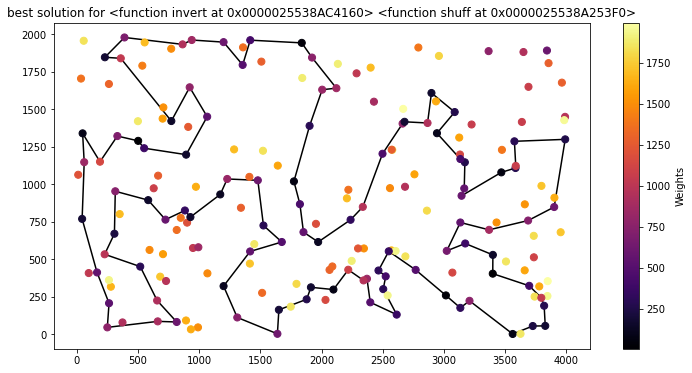

scores:  69440 70389.75 71500
[171, 16, 25, 44, 120, 78, 145, 179, 57, 92, 129, 2, 75, 86, 101, 1, 152, 97, 26, 100, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 149, 131, 65, 116, 43, 42, 184, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 181, 146, 22, 159, 193, 41, 115, 46, 68, 139, 18, 108, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 148, 9, 62, 144, 14, 49, 178, 106, 52, 55, 185, 40, 119, 165, 90, 81, 196, 157, 31, 56, 113, 175]
execution time: 25.000000476837158 25.002101135253906 25.004989624023438
ils iterations:  6714 6761.35 6816


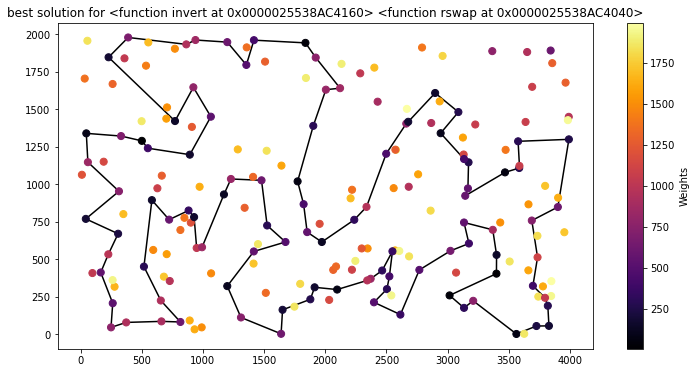

scores:  69927 70195.35 70406
[43, 42, 184, 35, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 181, 146, 22, 18, 108, 159, 193, 41, 139, 115, 46, 68, 140, 93, 117, 0, 143, 183, 89, 137, 176, 80, 133, 79, 63, 94, 124, 148, 9, 62, 144, 102, 49, 14, 138, 165, 27, 90, 81, 196, 40, 119, 185, 106, 3, 178, 52, 55, 57, 92, 179, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 129, 2, 75, 86, 101, 1, 152, 97, 26, 100, 53, 180, 154, 135, 70, 127, 123, 162, 151, 51, 118, 59, 65, 116]
execution time: 25.003989696502686 25.022949969768526 25.059990882873535
ils iterations:  1316 1402.7 1463


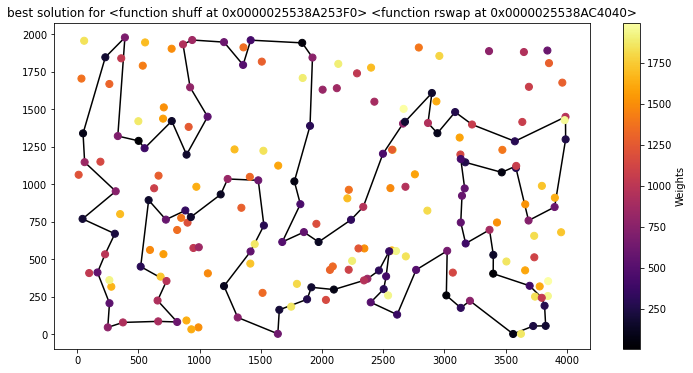

scores:  70159 70571.4 71077
[177, 10, 190, 4, 112, 84, 184, 42, 43, 116, 65, 131, 149, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 129, 82, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 92, 57, 55, 52, 185, 40, 90, 165, 106, 178, 3, 49, 14, 144, 102, 62, 9, 15, 148, 167, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46, 115, 139, 41, 193, 159, 108, 18, 22, 146, 181, 34, 160, 48, 54]
execution time: 25.000000476837158 25.01855297088623 25.06099820137024
ils iterations:  1109 1176.7 1249


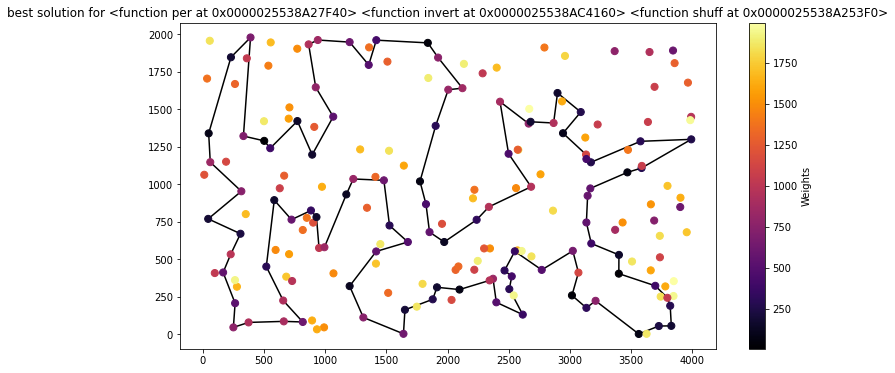

scores:  69830 70599.8 71468
[62, 9, 148, 94, 63, 79, 133, 162, 151, 51, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 108, 18, 22, 146, 195, 159, 193, 41, 139, 68, 46, 115, 118, 59, 65, 116, 43, 42, 181, 34, 160, 48, 54, 177, 10, 190, 184, 84, 4, 112, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 179, 92, 129, 57, 55, 52, 178, 3, 106, 165, 40, 185, 196, 81, 90, 164, 7, 21, 144, 14, 49, 102]
execution time: 25.0 25.005199217796324 25.01399302482605
ils iterations:  2994 3017.75 3057


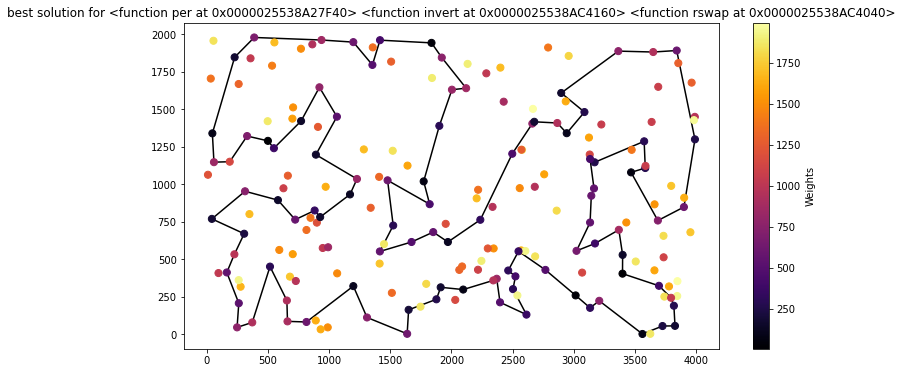

scores:  70006 70494.1 70956
[151, 133, 162, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 129, 57, 92, 82, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 179, 196, 81, 90, 165, 119, 40, 185, 55, 52, 106, 178, 49, 14, 144, 102, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 89, 183, 143, 0, 117, 93, 140, 108, 18, 68, 46, 139, 41, 193, 159, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 184, 35, 84, 4, 112, 123, 149, 131, 65, 116, 43, 42, 115, 59, 118, 51]
execution time: 25.00000023841858 25.01860091686249 25.090009927749634
ils iterations:  1044 1112.45 1216


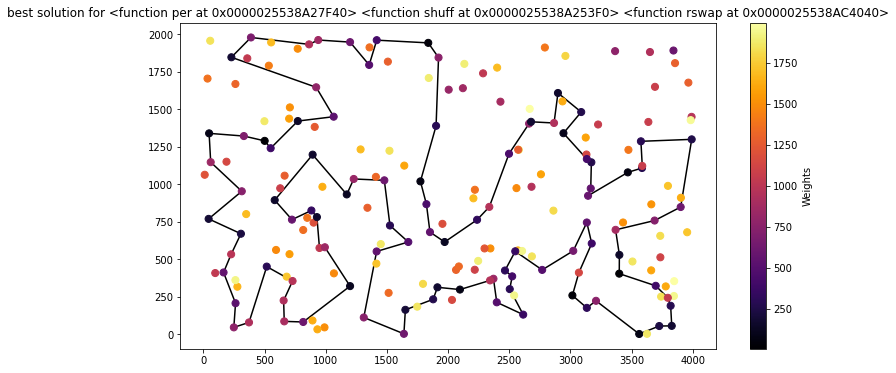

scores:  69666 70145.35 70475
[180, 154, 135, 70, 127, 123, 162, 151, 51, 118, 59, 149, 65, 116, 43, 42, 181, 160, 184, 84, 112, 4, 190, 10, 177, 54, 34, 103, 146, 22, 159, 193, 41, 139, 115, 46, 68, 18, 108, 140, 93, 117, 0, 143, 183, 89, 23, 137, 176, 80, 133, 79, 63, 94, 124, 148, 9, 62, 144, 14, 102, 49, 3, 178, 106, 52, 55, 57, 129, 92, 179, 185, 40, 119, 165, 90, 81, 196, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100, 121, 53]
execution time: 25.000000476837158 25.02166234254837 25.063997745513916
ils iterations:  1287 1376.6 1446


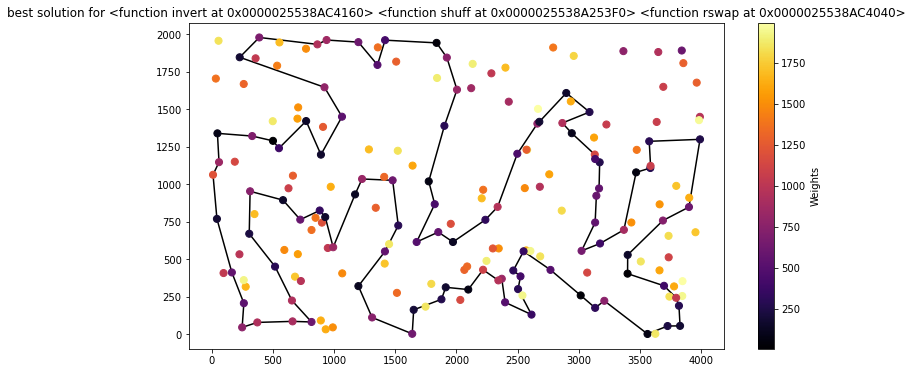

scores:  70209 70518.4 70796
[165, 90, 81, 196, 31, 56, 113, 175, 171, 16, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100, 121, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 115, 46, 139, 41, 193, 159, 181, 42, 43, 116, 65, 149, 35, 84, 112, 4, 184, 10, 177, 54, 48, 160, 34, 103, 146, 22, 18, 69, 108, 140, 93, 117, 0, 143, 183, 89, 137, 176, 80, 79, 63, 94, 124, 148, 9, 62, 102, 49, 144, 14, 178, 106, 52, 55, 57, 92, 129, 82, 78, 145, 179, 185, 40, 119]
execution time: 25.00000500679016 25.02651242017746 25.083999156951904
ils iterations:  1021 1071.85 1121


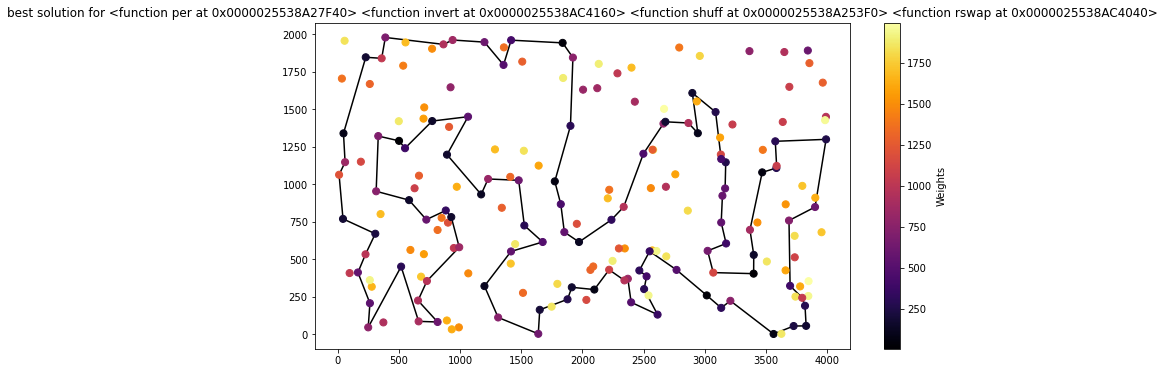

In [16]:
for combination in all_combinations:
    test_method(neighborhood, dist, costs, coordinates, pert_f=combination, name=' '.join([str(x) for x in combination]))